In [7]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from os import path
from PIL import Image
from sklearn import feature_extraction
import mpld3
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [8]:
notes = pd.read_csv('CHW_Notes.csv')

In [10]:
notes

,patient_id,text
0,2,A healthy lifestyle is important because hav...
1,6,"Diabetes runs in family - grandmother, mothe..."
2,13,"Prior to bariatric surgery, I was having lot..."
3,14,Healthy lifestyle is important to me because...
4,19,I had endometrial cancer 4 years ago when I ...
...,...,...
76,304,I am colon cancer survivor and Buddhist. I e...
77,314,"Living a good, happy life with my kids. .Fee..."
78,319,to enjoy my family without worrying about be...
79,323,....Importance of maintaining physical activ...


# Make a word cloud

In [60]:
text_all = ''.join(text for text in notes.text)
print('There are {} words in the combination of all notes.'.format(len(text_all)))

There are 252724 words in the combination of all notes.


In [66]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords_set = set(stopwords)
# add self-defined stopwords
stopwords_set.update(['pc','pt', 'pcp', 'a1c','patient','need', 'able', 'stated', 'get', 'day','said', 'also', 'since', 'want','due','discussed','still','getting','appt'])


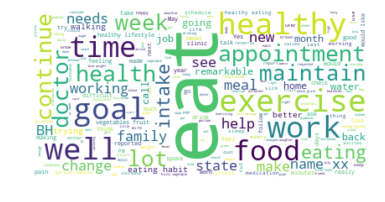

In [67]:
wordcloud = WordCloud(stopwords = stopwords_set,background_color="white").generate(text_all)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
#wordcloud.to_file("img/first_review.png")

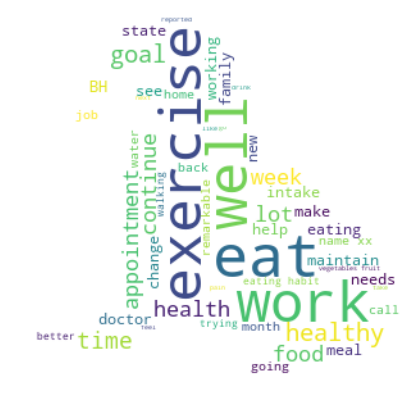

In [71]:
mask = np.array(Image.open("seal.png"))
wordcloud_seal = WordCloud(stopwords=stopwords_set, background_color="white", mode="RGBA", max_words=50, mask=mask).generate(text_all)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud_seal,interpolation="bilinear")
plt.axis("off")

# store to file
#plt.savefig("img/us_wine.png", format="png")

plt.show()

# Stopwords, stemming, and tokenizing

In [25]:
# see stopwords in word cloud section

In [72]:
stemmer = SnowballStemmer('english')
lem = WordNetLemmatizer()

### Define a tokenizer and stemmer which returns the set of stems in the text that it is passed

In [83]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [lem.lemmatize(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [84]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in notes.text:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'text', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [154]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')


there are 43587 items in vocab_frame


In [155]:
vocab_frame

,words
A,a
healthy,healthy
lifestyle,lifestyle
is,is
important,important
...,...
oil,oils
such,such
a,as
palm,palm


# Tf-idf and document similarity

In [156]:
# define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                  min_df=0.2, stop_words='english',
                                  use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(notes['text'])
print(tfidf_matrix.shape)

/Users/dengshuyang/miniconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 865 ms, sys: 53.9 ms, total: 919 ms
Wall time: 955 ms
(81, 173)


In [157]:
terms = tfidf_vectorizer.get_feature_names()

In [158]:
len(terms)

173

In [159]:
# Similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# K-means clustering

In [160]:
from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 240 ms, sys: 3.55 ms, total: 244 ms
Wall time: 248 ms


In [161]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [162]:
id_list = list(notes['patient_id'])

In [163]:
notes_dic = { 'patient_id': id_list, 'text': notes['text'], 'cluster': clusters}

frame = pd.DataFrame(notes_dic, index = [clusters] , columns = ['patient_id', 'cluster'])


In [164]:
frame

,patient_id,cluster
2,2,2
0,6,0
0,13,0
2,14,2
1,19,1
...,...,...
0,304,0
0,314,0
2,319,2
0,323,0


In [165]:
frame['cluster'].value_counts()

0    37
2    26
1    18
Name: cluster, dtype: int64

### Here is some fancy indexing and sorting on each cluster to identify which are the top n (I chose n=6) words that are nearest to the cluster centroid. This gives a good sense of the main topic of the cluster

In [174]:
# debug non exist/inconsistent words
remove_list = ['pc','pt', 'pcp', 'a1c','patient','need', 'able', 'stated', 'get', 'day','said', 'also', 'since', 'want','due','discussed','still','getting','appt']
new_terms = [i for i in terms if i not in remove_list]

In [176]:
len(new_terms)

159

In [177]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :8]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[new_terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d patient_id:" % i, end='')
    for patient_id in frame.loc[i]['patient_id']:
        print(' %s,' % patient_id, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b'portion', b'pain', b'reports', b'live', b'better', b'yes', b'high', b'physical',

Cluster 0 patient_id: 6, 13, 24, 31, 34, 49, 65, 71, 77, 94, 106, 109, 117, 131, 149, 154, 156, 162, 178, 180, 195, 216, 224, 226, 230, 231, 239, 250, 262, 266, 267, 273, 275, 280, 304, 314, 323,

Cluster 1 words: b'portion', b'try', b'vegetables', b'yes', b't', b'drinking', b'asked', b'means',

Cluster 1 patient_id: 19, 41, 48, 54, 78, 85, 92, 103, 128, 129, 182, 188, 244, 245, 268, 269, 272, 298,

Cluster 2 words: b'sick', b'hours', b'small', b'foods', b'patient', b'green', b'months', b'exercise',

Cluster 2 patient_id: 2, 14, 51, 63, 69, 75, 82, 88, 101, 134, 136, 146, 151, 203, 237, 238, 242, 246, 248, 252, 256, 292, 296, 303, 319, 327,





# Multidimensional scaling

In [127]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

# Visualizing document clusters

In [178]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3' }

#set up cluster names using a dict
cluster_names = {0: 'pain, better, physical', 
                 1: 'try, vegetables, drinking', 
                 2: 'sick, foods, exercise'}

In [188]:
patient_id

327

/Users/dengshuyang/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/dengshuyang/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/dengshuyang/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


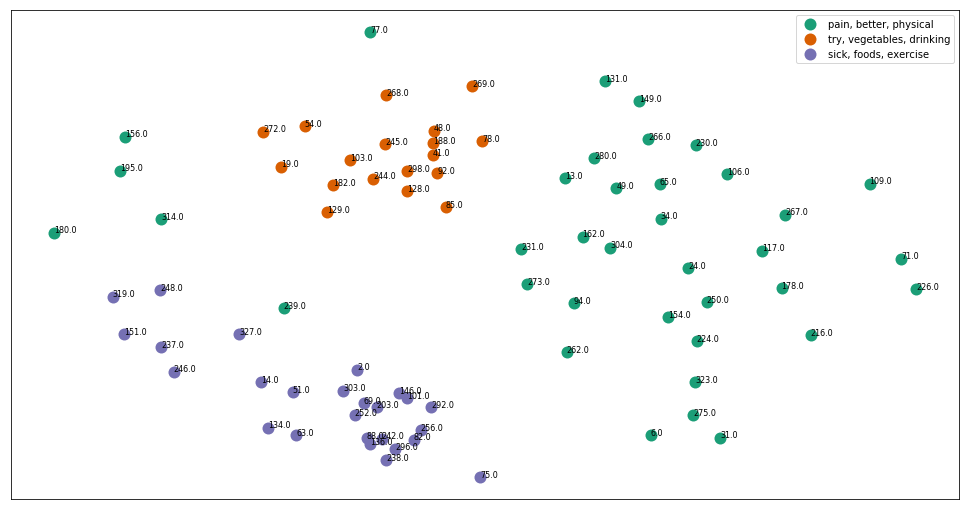

In [189]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=notes.patient_id)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

# Play with Mpld3 (java)

In [185]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [190]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=notes.patient_id)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot


In [191]:
#uncomment the below to export to html
html = mpld3.fig_to_html(fig)
#print(html)
#with open("mpld3.html", "w") as file:
    #file.write(html)



<style>

text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}

text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}

text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}

</style>

<div id="fig_el694321121605090089848029043"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create th

# References:
http://stanford.edu/~cpiech/cs221/handouts/kmeans.html
<br>
https://nlpforhackers.io/topic-modeling/
<br>
http://brandonrose.org/clustering
<br>
https://en.wikipedia.org/wiki/K-means_clustering
<br>
https://en.wikipedia.org/wiki/Tf%E2%80%93idf
<br>
http://www.tfidf.com/
<br>
https://www.elephate.com/blog/what-is-tf-idf/
<br>
https://www.datacamp.com/community/tutorials/wordcloud-python
<br>
https://d3js.org/